In [37]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import logging

from scipy.stats.mstats import winsorize
from scipy.stats import shapiro, mannwhitneyu

from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score, make_scorer,
                             f1_score, roc_auc_score, auc, roc_curve, r2_score, mean_squared_error)
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier          
from sklearn.pipeline import Pipeline    
from sklearn.inspection import PartialDependenceDisplay

import xgboost as xgb

In [2]:
df = pd.read_csv('accepted_stocks_fixed.00-25.csv')

In [3]:
# Fixing existing columns where data is sometimes found in another column
# Took a broad sample of indiscrepancies in these columns and verified with financial docs found online.
# This is a reasonable fix that solves around 98% of the mismatch.
df['totalCurrentLiabilities'] = df['totalCurrentLiabilities'].fillna(df['totalLiabilities'])
df['totalEquity'] = df['totalLiabilitiesAndTotalEquity'] - df['totalLiabilities']

# Calculate returns
df['ROE'] = df['netIncome_x'] / df['totalEquity']
df['ROA'] = df['netIncome_x'] / df['totalAssets']
df['ROI'] = df['netIncome_x'] / df['totalInvestments']
df['log_return'] = np.log(df['Adj Close'] / df.groupby('symbol_stock')['Adj Close'].shift(1))

# Debt Ratios
df['debtToEquity'] = df['totalDebt'] / df['totalEquity']
df['netDebtRatio'] = df['netDebt'] / df['totalAssets']
df['debt_ratio'] = df['totalLiabilities'] / df['totalAssets'] 

# Cash flow ratios
df['free_cash_flow_yield'] = df['freeCashFlow'] / df['totalEquity']
df['Op_Cash_Flow_to_Revenue'] = df['operatingCashFlow'] / df['revenue']
df['Op_Cash_Flow_to_Liabilities'] = df['operatingCashFlow'] / df['totalCurrentLiabilities']

# Inventory, interest, investment
df['inventoryTurnover'] = df['costOfRevenue'] / df['inventory_x']
df['inventory_to_assets'] = df['inventory_x'] / df['totalAssets']
df['interest_coverage'] = df['operatingIncome'] / df['interestExpense']
df['longinvest_to_assets'] = df['longTermInvestments'] / df['totalAssets'] 
df['longinvest_to_equity'] = df['longTermInvestments'] / df['totalEquity'] 
df['totalInvestments_to_assets'] = df['totalInvestments'] / df['totalAssets']

# Other important ratios
df['Profit_Margin'] = df['netIncome_x'] / df['revenue']

df['retained_earnings'] = df['netIncome_x'] - df['dividendsPaid']
df['re_ratio'] = df['retained_earnings'] / df['netIncome_x']

df['currentRatio'] = df['totalCurrentAssets'] / df['totalCurrentLiabilities']
df['cash_ratio'] = df['cashAndShortTermInvestments'] / df['totalCurrentLiabilities']

df['capital_light'] = df['capitalExpenditure'] / df['operatingCashFlow']
df['liabilitiesToEquity'] = df['totalLiabilities'] / df['totalEquity']
df['taxAssetsRatio'] = df['taxAssets'] / df['totalAssets']
df['Deferred_Revenue_to_Revenue'] = df['deferredRevenue'] / df['revenue'].replace(0, np.nan)
df['Deferred_Revenue_to_Current_Liabilities'] = df['deferredRevenue'] / df['totalCurrentLiabilities'].replace(0, np.nan)
df['goodwillIntangible_to_assets'] = df['goodwillAndIntangibleAssets'] / df['totalAssets']
df['sellingMarketing_to_revenue'] = df['sellingAndMarketingExpenses'] / df['revenue']
df['rnd_to_revenue'] = df['researchAndDevelopmentExpenses'] / df['revenue']


# Valuation Metrics
df['Book_Value_per_share'] = df['totalStockholdersEquity'] / df['weightedAverageShsOut']
df['PE_ratio'] = df['Adj Close'] / df['eps'].replace(0, np.nan)
df['PB_ratio'] = df['Adj Close'] / df['Book_Value_per_share'].replace(0, np.nan)

/Users/arshsingh/Documents/Montclair/portfolio-masters-capstone/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [4]:
sp_df = pd.read_csv('sp.csv')

def date_parser(date_str, max_year=2025):
    """
    Parse a date string with two-digit year. If the parsed year is greater than
    max_year, assume it belongs to the previous century.
    
    Parameters:
    - date_str: The date string (e.g., "12/30/27").
    - max_year: The maximum acceptable year (e.g., 2025). If the parsed year is higher,
      subtract 100.
    
    Returns:
    - A datetime object.
    """
    dt = pd.to_datetime(date_str, format="%m/%d/%y")
    # If year is greater than max_year (2025), assume it should be in the 1900s and subtract 100 years.
    if dt.year > max_year:
        dt = dt.replace(year=dt.year - 100)
    return dt

sp_df['Date'] = sp_df['Date'].apply(date_parser)

# Remove rows with dates before 1999
sp_df = sp_df[sp_df['Date'] >= pd.Timestamp('1999-01-01')]

df['acceptedDate'] = pd.to_datetime(df['acceptedDate'])
sp_df['Date'] = pd.to_datetime(sp_df['Date'])
sp_df.rename(columns={'Date': 'acceptedDate'}, inplace=True)
df = df.sort_values('acceptedDate')
sp_df = sp_df.sort_values('acceptedDate')

# Merging stock data with SP500 data to allow for calculation of relative return
df = pd.merge_asof(
    df,
    sp_df,            
    on='acceptedDate',
    direction='backward', 
    suffixes=('', '_sp')
)


df['accepted_date'] = pd.to_datetime(df['acceptedDate'])
# The model will be trained on quarterly returns
# horizon_days = 365 * 1  # 5-year return horizon
horizon_days = 90
df['target_date'] = df['accepted_date'] + pd.Timedelta(days=horizon_days)

df = df.sort_values(by=['symbol_stock', 'accepted_date'])

In [5]:
# Add growth rates
df['revenue_growth_quarterly'] = df.groupby('symbol_stock')['revenue'].pct_change(periods=1)
df['revenue_growth_annual'] = df.groupby('symbol_stock')['revenue'].pct_change(periods=4)

df['eps_growth_quarterly'] = df.groupby('symbol_stock')['epsdiluted'].pct_change(periods=1)
df['eps_growth_annual'] = df.groupby('symbol_stock')['epsdiluted'].pct_change(periods=4)

# Add Lag Features
lag_features = ['ROE', 'ROA', 'free_cash_flow_yield', 're_ratio', 'Profit_Margin',
                'debtToEquity', 'eps', 'epsdiluted', 'ebitda', 'goodwillIntangible_to_assets',
                'sellingMarketing_to_revenue', 'totalInvestments_to_assets', 'rnd_to_revenue',
                'inventory_to_assets']
for feature in lag_features:
    df[f'{feature}_lag1'] = df.groupby('symbol_stock')[feature].shift(1)
    df[f'{feature}_lag4'] = df.groupby('symbol_stock')[feature].shift(4)

rolling_features = ['ROE', 'ROA', 'free_cash_flow_yield', 're_ratio', 'Profit_Margin',
                    'debtToEquity', 'eps', 'epsdiluted', 'ebitda', 'goodwillIntangible_to_assets',
                    'sellingMarketing_to_revenue', 'totalInvestments_to_assets', 'rnd_to_revenue',
                    'inventory_to_assets']
for feature in rolling_features:
    # Using a 4-quarter window
    df[f'{feature}_roll4'] = df.groupby('symbol_stock')[feature].transform(
        lambda x: x.rolling(window=4, min_periods=1).mean()
    )

for feature in rolling_features:
    # Using a 8-quarter window
    df[f'{feature}_roll8'] = df.groupby('symbol_stock')[feature].transform(
        lambda x: x.rolling(window=8, min_periods=1).mean()
)

In [6]:
# Calculate quarterly returns
# Merge df onto itself by using data from +90 days from the current row

df_prices = df[['symbol_stock', 'accepted_date', 'Adj Close', 'Close']].rename(
    columns={'accepted_date': 'future_date', 'Adj Close': 'future_price', 'Close': 'future_dji'}
).sort_values('future_date')

df = df.dropna(subset=['accepted_date'])
# df['target_date'] = df['accepted_date'] + pd.Timedelta(days=365 * 1)
df['target_date'] = df['accepted_date'] + pd.Timedelta(days=90 * 1)
df_prices = df_prices.dropna(subset=['future_date'])

df_model = pd.merge_asof(
    left=df.sort_values('target_date'),
    right=df_prices,
    left_on='target_date',
    right_on='future_date',
    by='symbol_stock',
    direction='forward'
)

In [7]:
final_df = df_model.copy()

# Calculate the SP500 log return over the period and also the log return for each row of the stock dataset
# Subtract the SP500 log return from the row's return to get relative return
final_df['log_dji_return'] = np.log(final_df['future_dji'] / final_df['Close'])

final_df['log_return_future'] = np.log(final_df['future_price'] / final_df['Adj Close'])
final_df = final_df.dropna(subset=['log_return_future']).copy()

final_df['relative_log_return'] = final_df['log_return_future'] - final_df['log_dji_return']

# Define threshold for it to be a 'good_stock' as the log of (1 + 2%) approximately 0.0198
threshold = np.log(1 + 0.02)

# Create the binary target
final_df['good_stock'] = (final_df['relative_log_return'] > threshold).astype(int)
print(final_df['good_stock'].value_counts())

# Drop rows where any of these columns have NAN or infinite values
cols_to_check = ['Book_Value_per_share', 'PE_ratio', 'PB_ratio']
final_df = final_df[np.isfinite(final_df[cols_to_check]).all(axis=1)]

final_df.reset_index(drop=True, inplace=True)

print("Cleaned DataFrame shape:", final_df.shape)

/Users/arshsingh/Documents/Montclair/portfolio-masters-capstone/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


good_stock
0    123613
1     99187
Name: count, dtype: int64
Cleaned DataFrame shape: (221743, 247)


In [8]:
stock_prices = pd.read_csv('adjclose_stock.csv')

# Calculate market cap
stock_prices['Market Cap'] = stock_prices['Adj Close'] * stock_prices['Volume']

# Define categories of Market Cap to keep and filter 
def categorize_market_cap(market_cap):
    if market_cap >= 200_000_000_000:
        return 'Mega-cap'
    elif market_cap >= 10_000_000_000:
        return 'Big-cap'
    elif market_cap >= 2_000_000_000:
        return 'Mid-cap'
    elif market_cap >= 250_000_000:
        return 'Small-cap'
    elif market_cap >= 50_000_000:
        return 'Micro-cap'
    else:
        return 'Nano-cap'

stock_prices['Market Cap Category'] = stock_prices['Market Cap'].apply(categorize_market_cap)

categories_to_keep = ['Mega-cap', 'Big-cap', 'Mid-cap', 'Small-cap', 'Micro-cap',]# 'Nano-cap']

filtered_stock_prices = stock_prices[stock_prices['Market Cap Category'].isin(categories_to_keep)]

symbols_to_keep = filtered_stock_prices['Stock'].unique()
final_df = final_df[final_df['symbol_stock'].isin(symbols_to_keep)]

# Filtering by minimum Adj Close and minimum amount of  quarter numbers per stock 
# Idea here is that, for a portfolio, it would be better to have a more stable company with historical data
# that an investor can analyze.  Younger companies are more likely to fail. Smaller companies are more volatile.
# Smaller companies can be more attractive for a growth portfolio. 
final_df = final_df[final_df.groupby('symbol_stock')['Adj Close'].transform(lambda x: (x > 14).any())]
final_df = final_df.reset_index(drop=True)

final_df = final_df[final_df.groupby('symbol_stock')['quarter_number'].transform(lambda x: (x > 20).any())]
final_df = final_df.reset_index(drop=True)

Processing sector: Financial Services
Top Spearman correlations with good_stock:
Book_Value_per_share                     0.093726
Open                                     0.085263
Low                                      0.085195
High                                     0.084930
totalInvestments                         0.078388
longTermInvestments                      0.075606
shortTermInvestments                     0.074414
totalStockholdersEquity                  0.074314
cashAndShortTermInvestments              0.074227
totalEquity                              0.073323
totalLiabilitiesAndTotalEquity           0.072495
totalLiabilitiesAndStockholdersEquity    0.072495
totalAssets                              0.072038
goodwill                                 0.070277
goodwillAndIntangibleAssets              0.068635
totalLiabilities                         0.067599
future_dji                               0.065903
intangibleAssets                         0.062336
totalDebt          

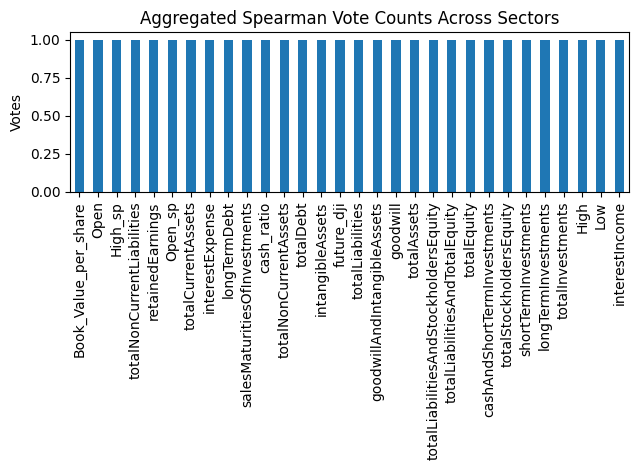

In [9]:
# Using Spearman correlations here as it is better when it comes to handling a binary target variable and non-linear relationships

# List the columns to ignore
ignore_cols = [
    'good_stock', 'calendarYear', 'calendarYear_y', 'calendarYear_x', 
    'Adj Close', 'quarter_number', 'future_price', 
    'cik_x', 'cik_y', 'cik', 'Unnamed: 0.1', 'Unnamed: 0',
    'Return_future', 'relative_return', 'relative_log_return', 'log_return_future'  
]


fin_df = final_df[final_df['Sector'] == 'Financial Services']
# Get unique sectors (doesn't matter here since it is just one sector)
sectors = fin_df['Sector'].unique()

# Dictionary to store Spearman correlations for each sector
sector_spearman = {}

# Set how many top features per sector to consider as votes
top_n_per_sector = 30

# FGilter the dataframe per sector
for sector in sectors:
    print(f"Processing sector: {sector}")
    
    df_sector = fin_df[fin_df['Sector'] == sector].copy()

    df_sector_numeric = df_sector.select_dtypes(include=['number'])
    
    df_sector_numeric = df_sector_numeric.drop(columns=ignore_cols, errors='ignore')
    
    # Ensure the 'good_stock' column is present 
    if 'good_stock' not in df_sector.columns:
        print(f"Skipping sector '{sector}': 'good_stock' column not found.")
        continue
    
    df_sector_numeric['good_stock'] = df_sector['good_stock']
    
    spearman_corr = df_sector_numeric.corr(method='spearman')['good_stock'].drop('good_stock')
    
    # Sort features by the absolute Spearman correlation (descending) and take the top N features
    top_spearman = spearman_corr.abs().sort_values(ascending=False).head(top_n_per_sector)
    sector_spearman[sector] = top_spearman
    
    print("Top Spearman correlations with good_stock:")
    print(top_spearman)
    print("-" * 50)

# Aggregate the top features (votes) across sectors and count how many times each feature appears in the top lists
all_votes = []
for sector, top_feats in sector_spearman.items():
    all_votes.extend(top_feats.index.tolist())

vote_counts = Counter(all_votes)
vote_counts_df = pd.DataFrame.from_dict(vote_counts, orient='index', columns=['Votes'])
vote_counts_df = vote_counts_df.sort_values(by='Votes', ascending=False)

print("Aggregated Spearman vote counts across sectors:")
print(vote_counts_df)

vote_counts_df.plot(kind='bar', title='Aggregated Spearman Vote Counts Across Sectors', legend=False)
plt.ylabel('Votes')
plt.tight_layout()
plt.show()

In [10]:
fin_df = final_df[final_df['Sector'] == 'Financial Services'].copy()
fin_df['accepted_date'] = pd.to_datetime(fin_df['accepted_date'])

# Time-based train/test split to avoid lookahead bias/leakage
# Sometimes, these type of models can end up remembering companies
train_cutoff = pd.Timestamp("2016-01-01")
test_cutoff_end = pd.Timestamp("2023-03-31")

train_df = fin_df[fin_df['accepted_date'] < train_cutoff].copy()
test_df  = fin_df[(fin_df['accepted_date'] >= train_cutoff) & (fin_df['accepted_date'] <= test_cutoff_end)].copy()

target = 'good_stock'
features = [
    'ROA', 'ROE', 'ROI',
    'revenue_growth_quarterly', 'revenue_growth_annual', 'Profit_Margin',
    'PB_ratio', 
    'Deferred_Revenue_to_Current_Liabilities', 'Deferred_Revenue_to_Revenue', 
    'cash_ratio', 'debt_ratio',
    'totalInvestments_to_assets',  
    'ROE_lag1', 
    'epsdiluted_lag1', 'epsdiluted_lag4', 
    'ROE_roll4', 'ROE_roll8', 'ROA_roll4', 'ROA_roll8',   
    'free_cash_flow_yield_roll8',
    'Profit_Margin_roll4',
    'epsdiluted'
]

# Replace infinities and drop missing values
train_df = train_df.replace([np.inf, -np.inf], np.nan).dropna(subset=features + [target])
test_df = test_df.replace([np.inf, -np.inf], np.nan).dropna(subset=features + [target])

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


# As a model that predicts returns, a high accuracy (80-100%) is unlikely. In that case, the model is probably struggling
# with overfitting. The philosophy then would be to avoid bad investments. If we are creating a portfolio, the last thing
# we want to do is lose money. From there, the model should have a pool of stocks it considers healthy that it can then buy. 
def custom_recall_scorer(y_true, y_pred):
    """
    Computes the harmonic mean of recall for class 0 and class 1,
    but if recall for class 0 (not good) is less than 0.90, returns 0.
    This forces the grid search to favor models that have at least 90% recall for class 0.
    """
    recall0 = recall_score(y_true, y_pred, pos_label=0)
    recall1 = recall_score(y_true, y_pred, pos_label=1)
    if recall0 < 0.90:
        return 0.0
    if recall0 + recall1 == 0:
        return 0.0
    return 2 * (recall0 * recall1) / (recall0 + recall1)

custom_scorer = make_scorer(custom_recall_scorer, greater_is_better=True)

# Grid Search using the custom scorer
tscv = TimeSeriesSplit(n_splits=3)
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'max_features': [None, 'sqrt', 'log2']
}

rf_clf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf_clf,
                              param_grid=param_grid_rf,
                              scoring=custom_scorer,
                              cv=tscv,
                              verbose=1,
                              n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

print("Best parameters found:")
print(grid_search_rf.best_params_)

best_rf_model = grid_search_rf.best_estimator_

# Model evaluation on the test set
y_pred = best_rf_model.predict(X_test)
y_pred_prob = best_rf_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_prob))

Train shape: (10141, 22)
Test shape: (8172, 22)
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters found:
{'max_depth': 5, 'max_features': None, 'min_samples_split': 2, 'n_estimators': 100}

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.92      0.72      4764
           1       0.48      0.10      0.17      3408

    accuracy                           0.58      8172
   macro avg       0.53      0.51      0.44      8172
weighted avg       0.54      0.58      0.49      8172

Confusion Matrix:
[[4384  380]
 [3060  348]]
Accuracy: 0.5790504160548213
Precision: 0.47802197802197804
Recall: 0.10211267605633803
F1 Score: 0.16827852998065765
ROC AUC: 0.5288210027376687



Feature Importances:
cash_ratio                                 0.128321
epsdiluted_lag4                            0.122353
PB_ratio                                   0.077434
revenue_growth_annual                      0.067075
epsdiluted_lag1                            0.064489
totalInvestments_to_assets                 0.057575
debt_ratio                                 0.055424
Profit_Margin_roll4                        0.040328
ROI                                        0.036473
revenue_growth_quarterly                   0.035982
free_cash_flow_yield_roll8                 0.035163
ROE                                        0.034934
ROA                                        0.034866
ROA_roll4                                  0.034469
ROE_roll4                                  0.029828
ROE_lag1                                   0.027471
epsdiluted                                 0.025313
ROE_roll8                                  0.024614
ROA_roll8                                 

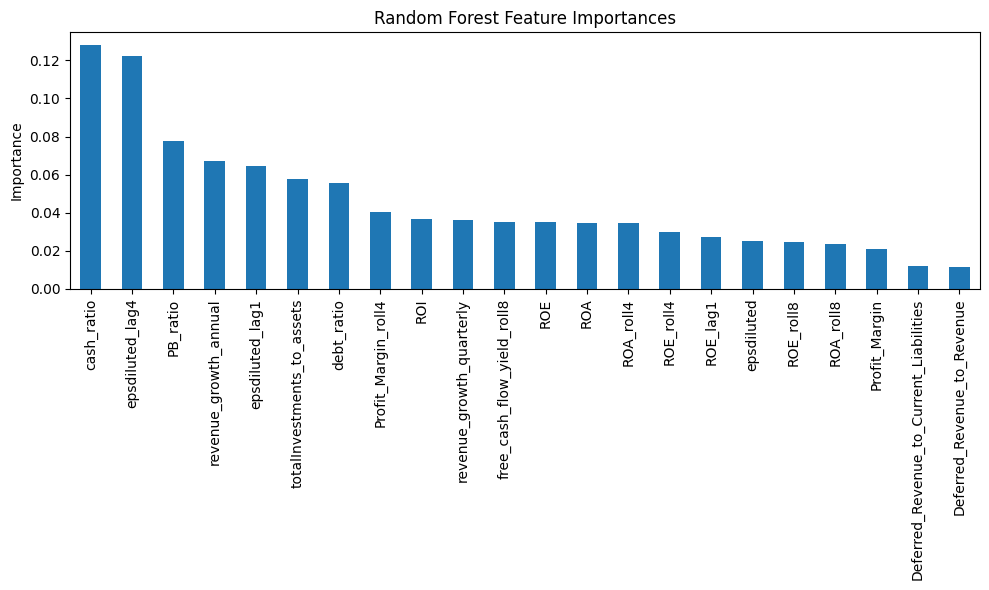

In [11]:
# Random Forests are extremely helpful in problems like this because of their ability to offer
# feature importances. In this case, we can see that cash ratio and EPS are the clear important features.
# This is reasonable as liquidity and earnings are extremely crucial in the Financial Services sector.
importances = best_rf_model.feature_importances_
feature_importances = pd.Series(importances, index=features).sort_values(ascending=False)
print("\nFeature Importances:")
print(feature_importances)

plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title("Random Forest Feature Importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

Trades Summary (first few rows):
  symbol_stock          entry_date           exit_date  trade_return Quarter
0           AB 2018-02-13 07:02:10 2019-02-13 07:17:51      0.279086  2019Q1
1           AB 2023-02-10 07:23:57 2023-02-10 07:23:57     -0.014000  2023Q1
2         ACGL 2019-02-28 16:14:41 2019-08-07 11:57:11      0.187714  2019Q3
3          AFG 2021-05-07 13:19:21 2021-08-06 12:29:01      0.147442  2021Q3
4          AIG 2022-02-17 15:27:18 2022-05-05 08:10:31      0.003618  2022Q2

Enhanced Trade-Level Backtest Performance:
Quarterly Trade Returns:
 2016Q1   -0.010000
2016Q2    0.135323
2016Q3    0.119799
2016Q4    0.206848
2017Q1    0.203836
2017Q2   -0.053733
2017Q3    0.143904
2017Q4    0.051759
2018Q1    0.109438
2018Q2   -0.017056
2018Q3    0.012828
2018Q4   -0.113322
2019Q1    0.288178
2019Q2    0.025300
2019Q3    0.010197
2019Q4    0.056815
2020Q1    0.286032
2020Q2   -0.208075
2020Q3   -0.030430
2020Q4    0.215483
2021Q1    0.244609
2021Q2    0.275801
2021Q3    0.06949

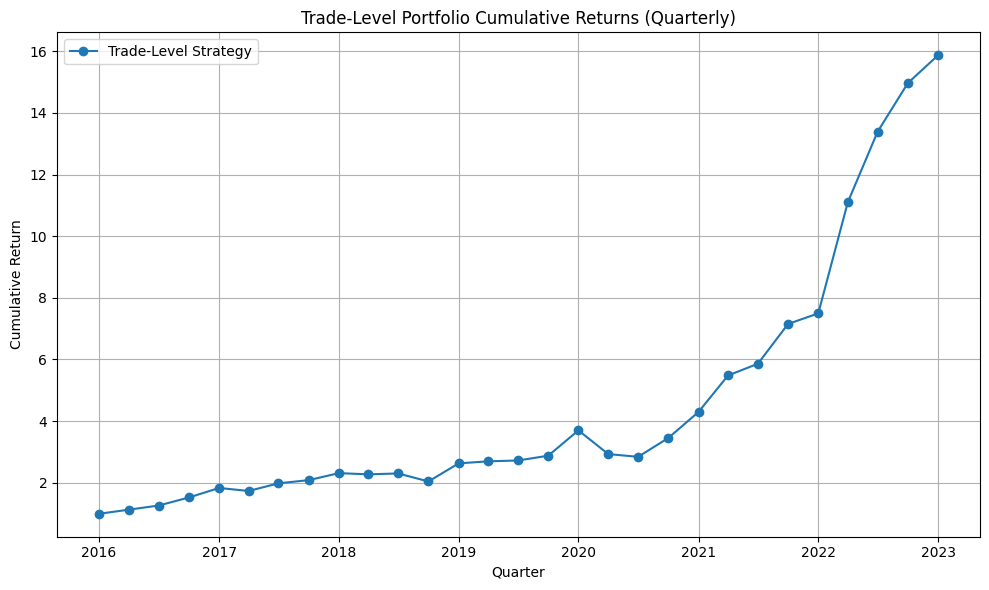

In [ ]:
# Parameters to make simulation more realistic
transaction_cost = 0.005  # 0.5% per trade (applied at entry and exit)
slippage = 0.002          # 0.2% additional cost per trade side

# Generate predicted signals (1 means buy/hold, 0 means not holding)
predicted_signal = best_rf_model.predict(X_test)
test_df.loc[X_test.index, 'predicted_signal'] = predicted_signal

test_sim = test_df.copy().sort_values(['symbol_stock', 'accepted_date'])

def simulate_trades_for_stock_baseline(stock_df, transaction_cost, slippage):
    """
    Simulate trades for one stock using the predicted signal.
    - When the signal is 1 and no position is open, "buy" at the current quarter's Adj Close.
    - When a position is open and the signal turns 0, "sell" at the current quarter's Adj Close.
    - When a position is open and the signal is still 1, hold the position.
    - If a position remains open until the end, close it at the last available price.
    
    Returns a list of dictionaries with 'symbol_stock', 'entry_date', 'exit_date', and 'trade_return'.
    """
    trades = []
    open_trade = None  # Will hold a dict with entry_date and entry_price when a trade is open
    
    # Iterate rows chronologically
    # Will research further to see if Adj Close should be used or if Open or another value would be better
    # Better meaning mimicing real-life
    for i, row in stock_df.iterrows():
        date = row['accepted_date']
        price = row['Adj Close']
        signal = row['predicted_signal']
        
        if open_trade is None:
            # No open position: if signal==1, then buy
            if signal == 1:
                open_trade = {
                    'entry_date': date,
                    'entry_price': price
                }
        else:
            # Position is open
            if signal == 0:
                # Sell signal: close trade at current price
                exit_price = price
                raw_return = exit_price / open_trade['entry_price'] - 1
                # Apply transaction costs and slippage on both entry and exit
                net_return = raw_return - 2 * (transaction_cost + slippage)
                trades.append({
                    'symbol_stock': row['symbol_stock'],
                    'entry_date': open_trade['entry_date'],
                    'exit_date': date,
                    'trade_return': net_return
                })
                open_trade = None  # Reset the open trade
            # If signal remains 1, we hold the position and do nothing
            
    # If a trade is still open at the end, close it at the last available price (this will have to be revised to see if there is
    # a better solution for this scenario)
    if open_trade is not None:
        last_row = stock_df.iloc[-1]
        exit_price = last_row['Adj Close']
        raw_return = exit_price / open_trade['entry_price'] - 1
        net_return = raw_return - 2 * (transaction_cost + slippage)
        trades.append({
            'symbol_stock': last_row['symbol_stock'],
            'entry_date': open_trade['entry_date'],
            'exit_date': last_row['accepted_date'],
            'trade_return': net_return
        })
    return trades

# Simulate thje trades
all_trades = []
for symbol, group in test_sim.groupby('symbol_stock'):
    trades = simulate_trades_for_stock_baseline(group, transaction_cost, slippage)
    all_trades.extend(trades)

trades_df = pd.DataFrame(all_trades)
trades_df['entry_date'] = pd.to_datetime(trades_df['entry_date'])
trades_df['exit_date'] = pd.to_datetime(trades_df['exit_date'])

# Quarter when the trade was closed 
trades_df['Quarter'] = trades_df['exit_date'].dt.to_period('Q')

print("Trades Summary (first few rows):")
print(trades_df.head())

# Compute the average trade return for trades that closed in each quarter
quarterly_trade_returns = trades_df.groupby('Quarter')['trade_return'].mean()

# To simulate the portfolio over time, reindex the series to include all quarters in the test period
all_quarters = pd.period_range(start=test_sim['accepted_date'].min().to_period('Q'),
                               end=test_sim['accepted_date'].max().to_period('Q'),
                               freq='Q')
# If a quarter had no trades, assume an opportunity cost (-1%)
quarterly_trade_returns = quarterly_trade_returns.reindex(all_quarters, fill_value=-0.01)

# Compute the cumulative returns and the important metrics such as the Sharpe Ratio
cumulative_returns = (1 + quarterly_trade_returns).cumprod()

annualized_return = (1 + cumulative_returns.iloc[-1]) ** (4 / len(cumulative_returns)) - 1 
sharpe_ratio = quarterly_trade_returns.mean() / quarterly_trade_returns.std() * np.sqrt(4)
peak = cumulative_returns.cummax()
drawdown = (cumulative_returns - peak) / peak
max_drawdown = drawdown.min()

print("\nBaselineTrade-Level Backtest Performance:")
print("Quarterly Trade Returns:\n", quarterly_trade_returns)
print("Cumulative Portfolio Returns:\n", cumulative_returns)
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")


plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns.index.to_timestamp(), cumulative_returns, marker='o', label='Trade-Level Strategy')
plt.title("Baseline Trade-Level Portfolio Cumulative Returns (Quarterly)")
plt.xlabel("Quarter")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# The baseline backtest assumes total portfolio rebalancing each quarter. To hold a longer-term portfolio,
# we change the function to account for holding a stock until the signal changes - either due to a negative return, 
# a deterioration of fundamentals, or a threshold for profit/loss. 
def simulate_trades_for_stock_enhanced(stock_df, transaction_cost, slippage,
                                       stop_loss=-0.05, take_profit=0.10, max_hold_periods=4,
                                       risk_per_trade=1000, account_balance=100000):
    """
    Enhanced simulation with risk management:
      - Buys on signal 1 and holds if signals remain positive.
      - Exits on stop-loss, take-profit, fundamentals deterioration, maximum holding period, or when signal turns negative.
      - Position sizing is based on fixed risk per trade.
    """
    trades = []
    open_trade = None
    hold_periods = 0
    
    def calculate_position_size(entry_price):
        risk_per_share = entry_price * abs(stop_loss)
        return risk_per_trade / risk_per_share if risk_per_share else 0
    
    for i, row in stock_df.iterrows():
        date = row['accepted_date']
        price = row['Adj Close']
        signal = row['predicted_signal']
        current_fundamentals = row.get('ROE', None)
        
        if open_trade is None:
            if signal == 1:
                position_size = calculate_position_size(price)
                open_trade = {
                    'entry_date': date,
                    'entry_price': price,
                    'position_size': position_size,
                    'entry_fundamentals': current_fundamentals
                }
                hold_periods = 1
        else:
            hold_periods += 1
            current_return = price / open_trade['entry_price'] - 1
            
            # Check stop-loss or take-profit conditions, exit if conditions are met
            if current_return <= stop_loss or current_return >= take_profit:
                exit_price = price
                raw_return = exit_price / open_trade['entry_price'] - 1
                net_return = raw_return - 2 * (transaction_cost + slippage)
                trades.append({
                    'symbol_stock': row['symbol_stock'],
                    'entry_date': open_trade['entry_date'],
                    'exit_date': date,
                    'trade_return': net_return,
                    'position_size': open_trade['position_size'],
                    'hold_periods': hold_periods,
                    'exit_reason': 'stop_loss/take_profit'
                })
                open_trade = None
                hold_periods = 0
                continue
            
            # Exit if fundamentals deteriorate (e.g., ROE drops >20%)
            if signal == 1 and open_trade['entry_fundamentals'] is not None and current_fundamentals is not None:
                if current_fundamentals < 0.8 * open_trade['entry_fundamentals']:
                    exit_price = price
                    raw_return = exit_price / open_trade['entry_price'] - 1
                    net_return = raw_return - 2 * (transaction_cost + slippage)
                    trades.append({
                        'symbol_stock': row['symbol_stock'],
                        'entry_date': open_trade['entry_date'],
                        'exit_date': date,
                        'trade_return': net_return,
                        'position_size': open_trade['position_size'],
                        'hold_periods': hold_periods,
                        'exit_reason': 'fundamentals_change'
                    })
                    open_trade = None
                    hold_periods = 0
                    continue
            
            # Force exit if maximum holding period is reached
            if hold_periods >= max_hold_periods:
                exit_price = price
                raw_return = exit_price / open_trade['entry_price'] - 1
                net_return = raw_return - 2 * (transaction_cost + slippage)
                trades.append({
                    'symbol_stock': row['symbol_stock'],
                    'entry_date': open_trade['entry_date'],
                    'exit_date': date,
                    'trade_return': net_return,
                    'position_size': open_trade['position_size'],
                    'hold_periods': hold_periods,
                    'exit_reason': 'max_hold_period'
                })
                open_trade = None
                hold_periods = 0
                continue
            
            # Exit trade if signal turns negative
            if signal == 0:
                exit_price = price
                raw_return = exit_price / open_trade['entry_price'] - 1
                net_return = raw_return - 2 * (transaction_cost + slippage)
                trades.append({
                    'symbol_stock': row['symbol_stock'],
                    'entry_date': open_trade['entry_date'],
                    'exit_date': date,
                    'trade_return': net_return,
                    'position_size': open_trade['position_size'],
                    'hold_periods': hold_periods,
                    'exit_reason': 'signal_change'
                })
                open_trade = None
                hold_periods = 0
                
    # Close any open trade at the end of the data
    if open_trade is not None:
        last_row = stock_df.iloc[-1]
        exit_price = last_row['Adj Close']
        raw_return = exit_price / open_trade['entry_price'] - 1
        net_return = raw_return - 2 * (transaction_cost + slippage)
        trades.append({
            'symbol_stock': last_row['symbol_stock'],
            'entry_date': open_trade['entry_date'],
            'exit_date': last_row['accepted_date'],
            'trade_return': net_return,
            'position_size': open_trade['position_size'],
            'hold_periods': hold_periods,
            'exit_reason': 'end_of_data'
        })
    return trades

Trades Summary (first few rows):
  symbol_stock          entry_date           exit_date  trade_return  \
0           AB 2018-02-13 07:02:10 2019-02-13 07:17:51      0.279086   
1           AB 2023-02-10 07:23:57 2023-02-10 07:23:57     -0.014000   
2         ACGL 2019-02-28 16:14:41 2019-08-07 11:57:11      0.187714   
3          AFG 2021-05-07 13:19:21 2021-08-06 12:29:01      0.147442   
4          AIG 2022-02-17 15:27:18 2022-05-05 08:10:31      0.003618   

   position_size  hold_periods            exit_reason Quarter  
0     717.386246             2  stop_loss/take_profit  2019Q1  
1     308.581977             1            end_of_data  2023Q1  
2     321.896842             3  stop_loss/take_profit  2019Q3  
3     123.728818             2  stop_loss/take_profit  2021Q3  
4     175.276460             2          signal_change  2022Q2  

Enhanced Trade-Level Backtest Performance:
Quarterly Trade Returns:
 2016Q1   -0.010000
2016Q2    0.108359
2016Q3    0.116547
2016Q4    0.041526
2017

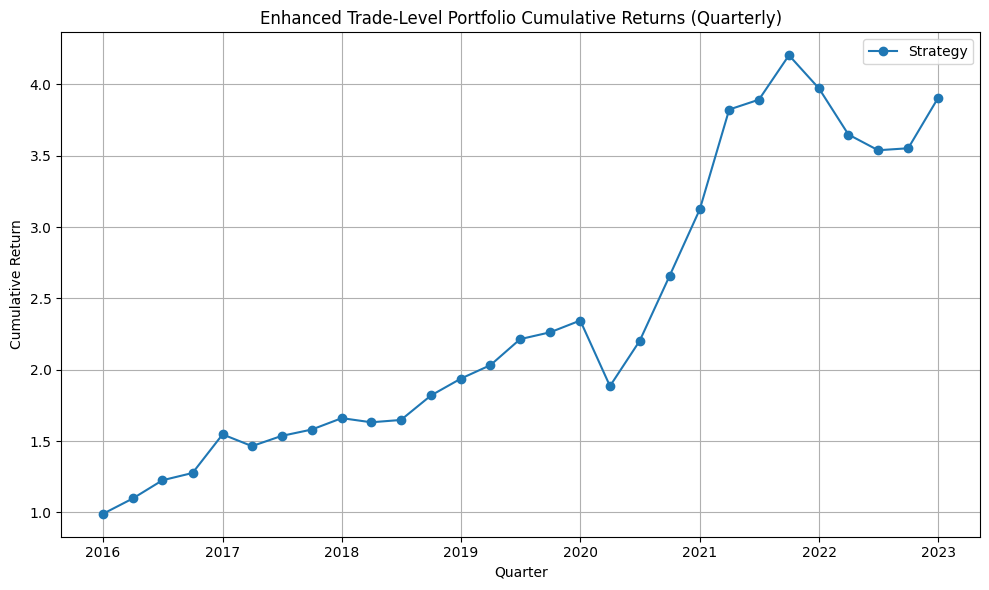

In [ ]:
# Run simulation
all_trades = []
for symbol, group in test_sim.groupby('symbol_stock'):
    trades = simulate_trades_for_stock_enhanced(group, transaction_cost, slippage,
                                 stop_loss=-0.1, take_profit=0.10,
                                 max_hold_periods=6, risk_per_trade=1000, account_balance=100000)
    all_trades.extend(trades)

# Default for stop_loss is -0.05 and max_hold_period is 4

trades_df = pd.DataFrame(all_trades)
trades_df['entry_date'] = pd.to_datetime(trades_df['entry_date'])
trades_df['exit_date'] = pd.to_datetime(trades_df['exit_date'])
trades_df['Quarter'] = trades_df['exit_date'].dt.to_period('Q')

print("Trades Summary (first few rows):")
print(trades_df.head())

# Aggregate trades by quarter
quarterly_trade_returns = trades_df.groupby('Quarter')['trade_return'].mean()

# Fill missing quarters with an assumed opportunity cost (-0.01)
all_quarters = pd.period_range(start=test_sim['accepted_date'].min().to_period('Q'),
                               end=test_sim['accepted_date'].max().to_period('Q'),
                               freq='Q')
quarterly_trade_returns = quarterly_trade_returns.reindex(all_quarters, fill_value=-0.01)

# Performance metrics
cumulative_returns = (1 + quarterly_trade_returns).cumprod()
n_quarters = len(cumulative_returns)
observed_annualized_return = (cumulative_returns.iloc[-1])**(4/n_quarters) - 1  # Annualize returns 
sharpe_ratio = quarterly_trade_returns.mean() / quarterly_trade_returns.std() * np.sqrt(4)
peak = cumulative_returns.cummax()
drawdown = (cumulative_returns - peak) / peak
max_drawdown = drawdown.min()

print("\nEnhanced Trade-Level Backtest Performance:")
print("Quarterly Trade Returns:\n", quarterly_trade_returns)
print("Cumulative Portfolio Returns:\n", cumulative_returns)
print(f"Observed Annualized Return: {observed_annualized_return:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")

plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns.index.to_timestamp(), cumulative_returns, marker='o', label='Strategy')
plt.title("Enhanced Trade-Level Portfolio Cumulative Returns (Quarterly)")
plt.xlabel("Quarter")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

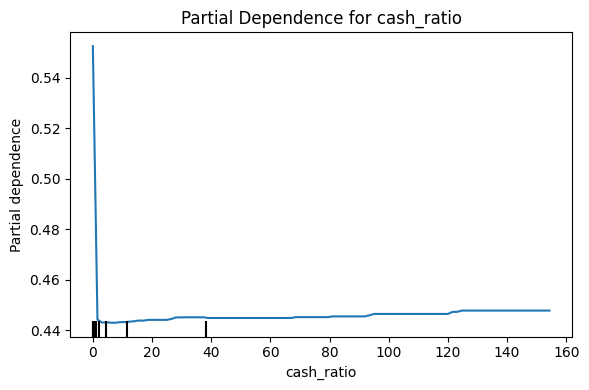

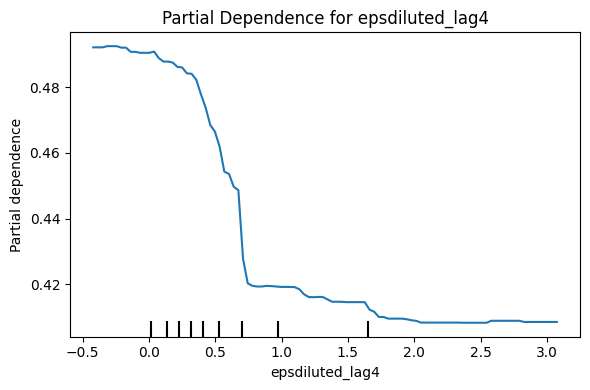

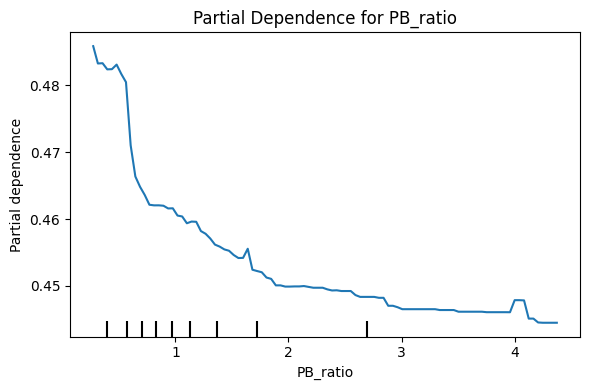

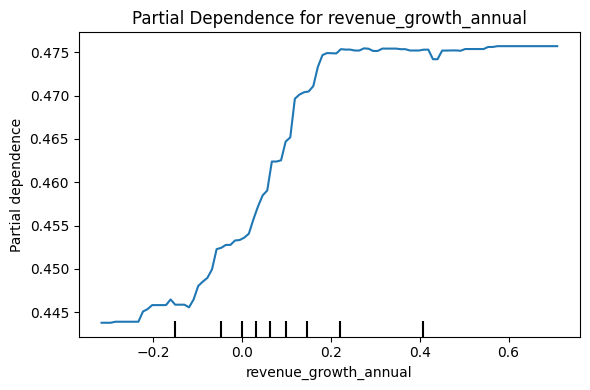

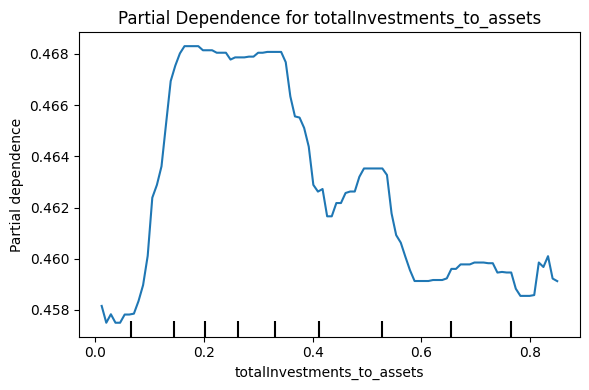

In [ ]:
# Using a Partial Dependence Plot to see the marginal effect of a feature on the predicted outcome of the model.
# It shows how the predicted response, in isolation, is influenced by the chosen feature.
# We can see that a higher lagged EPS might correlate with a lower probability of outperforming the SP500. 
# We can interpret as "high EPS in the past" might leave little room or value to grow. 
# Looking for "great companies at a fair value".
# Lower P/B ratio is interpreted as "value" aka undervalued stocks. The PDP for P/B ratio shows that 
# higher P/B ratios are associated with a lower chance of having a good relative return.
features_to_plot = ['cash_ratio', 'epsdiluted_lag4', 'PB_ratio', 'revenue_growth_annual', 'totalInvestments_to_assets']

for feature in features_to_plot:
    fig, ax = plt.subplots(figsize=(6, 4))
    PartialDependenceDisplay.from_estimator(
        best_rf_model,
        X_train,
        features=[feature],
        ax=ax
    )
    plt.title(f"Partial Dependence for {feature}")
    plt.tight_layout()
    plt.show()


Bootstrap Analysis on Annualized Return:
Mean Annualized Return (bootstrap): 20.91%
95% Confidence Interval: [5.60%, 36.87%]
P-value for annualized return = 0: 0.0062


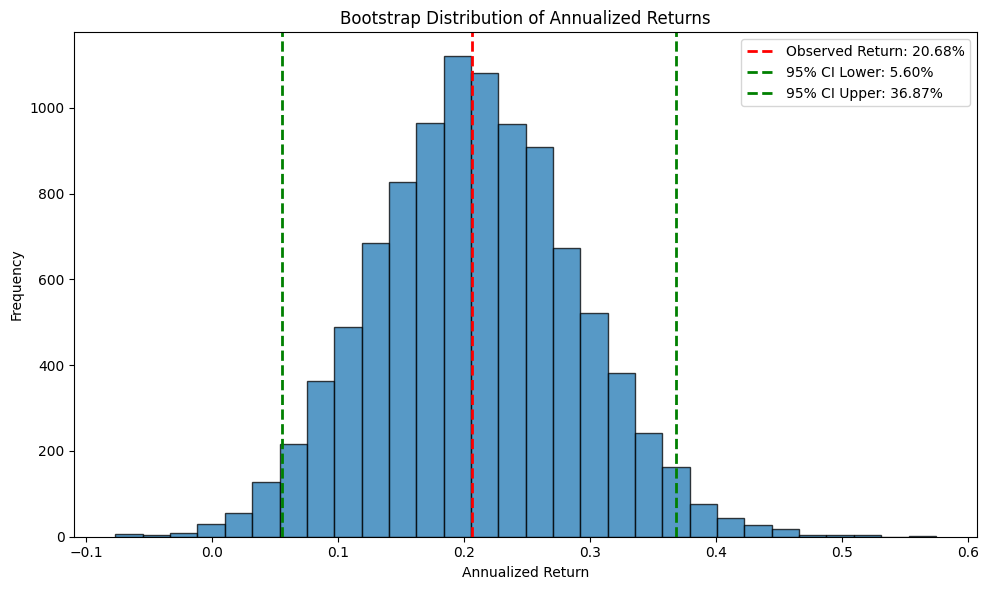

In [ ]:
# Implementing bootstrapping, a resampling technique which can be used to approx. the sampling distribution
# of a statistic (in this case, the quarterly returns) by repeatedly drawing samples from the data with replacement.
n_iterations = 10000 
bootstrap_annualized_returns = []
quarterly_returns_array = quarterly_trade_returns.values

for i in range(n_iterations):
    # Resample quarterly returns with replacement
    bootstrap_sample = np.random.choice(quarterly_returns_array, size=len(quarterly_returns_array), replace=True)
    cumulative_return_boot = np.prod(1 + bootstrap_sample)
    annualized_return_boot = cumulative_return_boot**(4/len(bootstrap_sample)) - 1
    bootstrap_annualized_returns.append(annualized_return_boot)

bootstrap_annualized_returns = np.array(bootstrap_annualized_returns)
ci_lower = np.percentile(bootstrap_annualized_returns, 2.5)
ci_upper = np.percentile(bootstrap_annualized_returns, 97.5)

if observed_annualized_return >= 0:
    p_value = 2 * np.mean(bootstrap_annualized_returns <= 0)
else:
    p_value = 2 * np.mean(bootstrap_annualized_returns >= 0)
p_value = min(p_value, 1.0)

print("\nBootstrap Analysis on Annualized Return:")
print(f"Mean Annualized Return (bootstrap): {np.mean(bootstrap_annualized_returns):.2%}")
print(f"95% Confidence Interval: [{ci_lower:.2%}, {ci_upper:.2%}]")
print(f"P-value for annualized return = 0: {p_value:.4f}")

plt.figure(figsize=(10, 6))
plt.hist(bootstrap_annualized_returns, bins=30, alpha=0.75, edgecolor='black')
plt.axvline(observed_annualized_return, color='red', linestyle='dashed', linewidth=2, 
            label=f'Observed Return: {observed_annualized_return:.2%}')
plt.axvline(ci_lower, color='green', linestyle='dashed', linewidth=2, 
            label=f'95% CI Lower: {ci_lower:.2%}')
plt.axvline(ci_upper, color='green', linestyle='dashed', linewidth=2, 
            label=f'95% CI Upper: {ci_upper:.2%}')
plt.title("Bootstrap Distribution of Annualized Returns")
plt.xlabel("Annualized Return")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


[Hierarchical (Block Bootstrap) Annualized Return Analysis:
Mean Annualized Return (bootstrap): 21.10%
95% Confidence Interval: [5.74%, 36.93%]
P-value for annualized return = 0: 0.0061


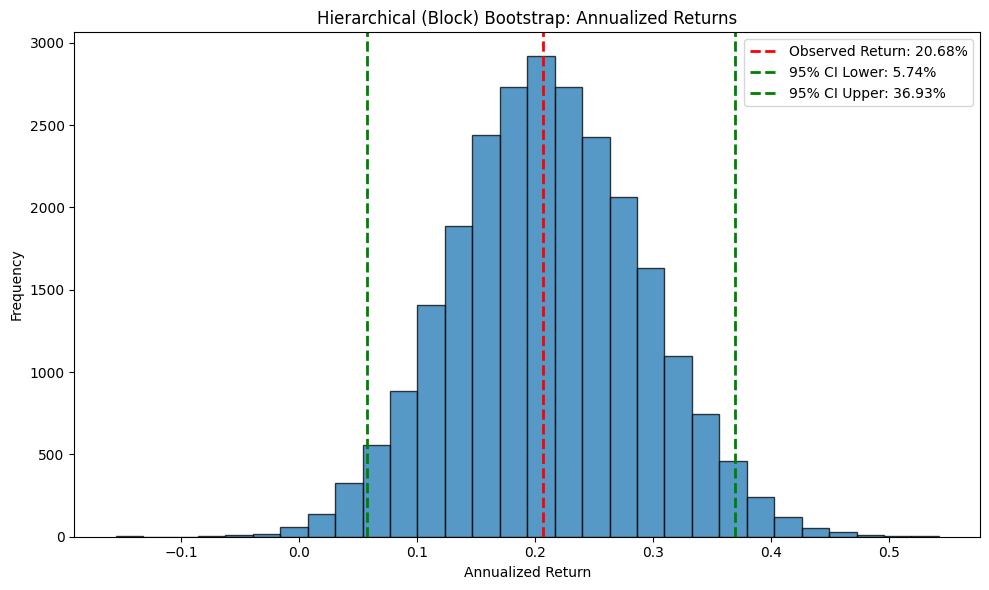

In [ ]:
# The bootstrapping above uses the quarterly returns. This is somewhat of an issue because there is only around 29 quarters to
# select from. To bootstrap in a different way, we resample at the trade level for each quarter, aggregate to the quarterly level
# and then bootstrap again. It accounts for variability within a quarter and between quarters, while also enabling use of the trades
# to sample from. This method is called Hierarchical, or Block, Bootstrapping.
def bootstrap_quarterly_return(trades_in_quarter, n_bootstrap=1000):
    """
    For a given quarter (DataFrame of trades), perform an inner bootstrap 
    to compute an aggregated quarterly return (here using the mean return).
    """
    boot_returns = []
    trade_returns = trades_in_quarter['trade_return'].values
    n_trades = len(trade_returns)
    for _ in range(n_bootstrap):
        # Resample trades for this quarter with replacement
        boot_sample = np.random.choice(trade_returns, size=n_trades, replace=True)
        boot_returns.append(np.mean(boot_sample))
    return np.mean(boot_returns)

# Get all unique quarters from trades_df
quarters = trades_df['Quarter'].unique()

# Bootstrap the quarterly return for each quarter using trade-level data
bootstrapped_quarterly_returns = {}
n_inner_bootstrap = 2000  # inner bootstrap iterations per quarter

for q in quarters:
    trades_q = trades_df[trades_df['Quarter'] == q]
    bootstrapped_quarterly_returns[str(q)] = bootstrap_quarterly_return(trades_q, n_bootstrap=n_inner_bootstrap)

boot_quarterly_returns = pd.Series(bootstrapped_quarterly_returns)
# Use the full quarter index from the simulation (all_quarters was defined earlier)
boot_quarterly_returns = boot_quarterly_returns.reindex(all_quarters.astype(str), fill_value=-0.01)

# Perform an outer bootstrap on the aggregated quarterly returns
n_outer_bootstrap = 25000
bootstrap_annualized_returns_hier = []
quarterly_returns_array = boot_quarterly_returns.values

for i in range(n_outer_bootstrap):
    # Resample the quarterly blocks - each block being a bootstrapped quarterly return)
    bootstrap_sample = np.random.choice(quarterly_returns_array, size=len(quarterly_returns_array), replace=True)
    cumulative_return = np.prod(1 + bootstrap_sample)
    annualized_return = cumulative_return**(4 / len(bootstrap_sample)) - 1
    bootstrap_annualized_returns_hier.append(annualized_return)

bootstrap_annualized_returns_hier = np.array(bootstrap_annualized_returns_hier)
ci_lower_hier = np.percentile(bootstrap_annualized_returns_hier, 2.5)
ci_upper_hier = np.percentile(bootstrap_annualized_returns_hier, 97.5)

if observed_annualized_return >= 0:
    p_value_hier = 2 * np.mean(bootstrap_annualized_returns_hier <= 0)
else:
    p_value_hier = 2 * np.mean(bootstrap_annualized_returns_hier >= 0)
p_value_hier = min(p_value_hier, 1.0)

print("\n[Hierarchical (Block Bootstrap) Annualized Return Analysis:")
print(f"Mean Annualized Return (bootstrap): {np.mean(bootstrap_annualized_returns_hier):.2%}")
print(f"95% Confidence Interval: [{ci_lower_hier:.2%}, {ci_upper_hier:.2%}]")
print(f"P-value for annualized return = 0: {p_value_hier:.4f}")

plt.figure(figsize=(10, 6))
plt.hist(bootstrap_annualized_returns_hier, bins=30, alpha=0.75, edgecolor='black')
plt.axvline(observed_annualized_return, color='red', linestyle='dashed', linewidth=2, 
            label=f'Observed Return: {observed_annualized_return:.2%}')
plt.axvline(ci_lower_hier, color='green', linestyle='dashed', linewidth=2, 
            label=f'95% CI Lower: {ci_lower_hier:.2%}')
plt.axvline(ci_upper_hier, color='green', linestyle='dashed', linewidth=2, 
            label=f'95% CI Upper: {ci_upper_hier:.2%}')
plt.title("Hierarchical (Block) Bootstrap: Annualized Returns")
plt.xlabel("Annualized Return")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()